In [3]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')


In the contralateral hemisphere, average the bimanual activity when a hand moved to a certain direction (e.g., leftHand-rightHand: 0-0, 0-60, 0-120, 0-180, 0-240, 0-300) with the unimanual condittion in which that hand moved to the same direction (e.g., leftHand 0).

## Left hand reach in Right Hem

In [2]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106,107,108,109,110,111,112,113,114,115]
hem = ['R']
atlas,_ = am.get_atlas('fs32k')

rdm_cols = ['lhand:0', 'lhand:60', 'lhand:120', 'lhand:180', 'lhand:240', 'lhand:300',
            'bi:0', 'bi:60', 'bi:120', 'bi:180', 'bi:240', 'bi:300']

G_matrices = {}
D_matrices = {}
for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()
    conds = np.array([cond.strip() for cond in np.array(conds)])
    
    for j, h in enumerate(hem):
        # ==========================================
        # DATA EXTRACTION
        # ==========================================
        #  Define atlas map
        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]
        
        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()

            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # Estimated variance-covariance matrix
            # ==========================================
            cond_vec = []
            part_vec = np.array([], dtype=int)
            Y = []
            for angle in [0,60,120,180,240,300]:
                # unimanual:
                idx = [(f'lhand:{angle}' in tmp) for tmp in conds]
                cond_vec.extend([cond.strip() for cond in np.array(conds)[idx]])
                part_vec = np.concatenate((part_vec,partitions[idx]))
                Y = np.vstack((Y, beta_white[idx,:])) if len(Y) else beta_white[idx,:]

                # bimanual:
                for k in range(1,11):
                    idx1 = np.array([(f'bi:{angle}' in tmp) for tmp in conds])
                    idx2 = np.array([(k == tmp) for tmp in partitions])
                    idx = idx1 & idx2
                    y_tmp = np.mean(beta_white[idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp))
                part_vec = np.concatenate((part_vec,np.arange(1,11)))
                cond_vec.extend([f'bi:{angle}'] * 10)
                
            cond_vec = np.array(cond_vec)
            Z = utils.please.indicator(cond_vec, rdm_cols)
            G_hat,_ = pcm.est_G_crossval(Y,
                                         Z,
                                         part_vec,
                                         X=pcm.matrix.indicator(part_vec))
            D = np.sign(pcm.G_to_dist(G_hat)) * np.sqrt(np.abs(pcm.G_to_dist(G_hat)))
            
            key = (sn, h, region_names[i])
            G_matrices[key] = G_hat
            D_matrices[key] = D

# Construct the long DataFrame
rows = []
for key in G_matrices:
    sn, hem, region = key
    G = G_matrices[key]
    D = D_matrices[key]

    row = {'sn': sn, 'hem': hem, 'region': region}
    row.update(utils.please.flatten_matrix(G, rdm_cols, 'G'))
    row.update(utils.please.flatten_matrix(D, rdm_cols, 'D'))
    rows.append(row)

ana = pd.DataFrame(rows)
ana.to_csv(os.path.join(analysisDir,'G_uni_bi_left.csv'), index=False)
ana.to_feather(os.path.join(analysisDir,'G_uni_bi_left.feather'))


### Plot D

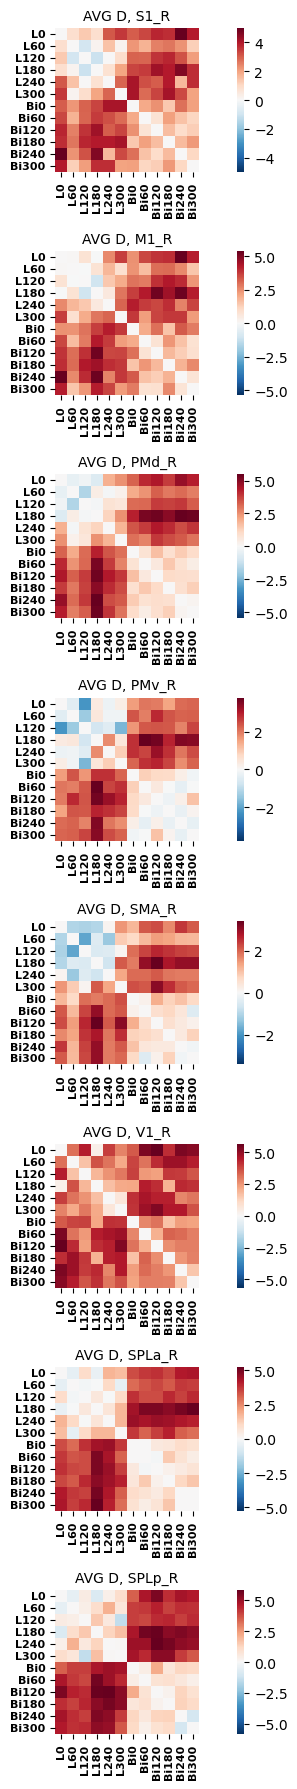

In [ ]:
ana = pd.read_feather(os.path.join(analysisDir,'G_uni_bi_left.feather'))

rdm_cols = ['lhand:0', 'lhand:60', 'lhand:120', 'lhand:180', 'lhand:240', 'lhand:300',
            'bi:0', 'bi:60', 'bi:120', 'bi:180', 'bi:240', 'bi:300']
labels = ['L0','L60','L120','L180','L240','L300',
          'Bi0','Bi60','Bi120','Bi180','Bi240','Bi300']
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

sn_list = ana.sn.unique()
hem = ana.hem.unique()
regions = ana.region.unique()

D_avg = np.zeros((len(hem),len(regions), len(rdm_cols), len(rdm_cols)))
n_cond = len(rdm_cols)
cmap = matplotlib.cm.RdBu.reversed()
for sn in sn_list:
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,18))
    for j, h in enumerate(hem):
        for i, ax in enumerate(axes.flat):
            row = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==region_names[i])]
            D = utils.please.retrieve_matrix(row, prefix='D', colnames=rdm_cols)
            v_max = np.max(D)
            v_min = np.min(D)
            v_max = max(abs(v_max), abs(v_min))
            
            # cmap_reversed = cmap.reversed()
            sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
            ax.set_title(f'D, {region_names[i]}_{h}, s{sn}', fontsize=10)

            # Set labels manually with more formatting options
            ax.set_xticks(np.arange(0,n_cond)+0.5)
            ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
            ax.set_yticks(np.arange(0,n_cond)+0.5)
            ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')

            # avg RDMs:
            D_avg[j,i,:,:] = D_avg[j,i,:,:] + D/len(sn_list)
        
    plt.tight_layout()
    plt.savefig(f'../figures/D_uni_vs_bi/s{sn}_leftHand.pdf', bbox_inches="tight")
    plt.close()

# AVG D PLOT:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,18))
for j, h in enumerate(hem):
    for i, ax in enumerate(axes.flat):
        D = D_avg[j,i,:,:]
        v_max = np.max(D)
        v_min = np.min(D)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
        ax.set_title(f'AVG D, {region_names[i]}_{h}', fontsize=10)
        
        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/D_uni_vs_bi/leftHand_avg.pdf', bbox_inches="tight")
plt.show()



## Right hand reach in left hem

In [27]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106,107,108,109,110,111,112,113,114,115]
hem = ['L']
atlas,_ = am.get_atlas('fs32k')

rdm_cols = ['rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240',
            'bi:180','bi:120','bi:60','bi:0','bi:300','bi:240']

G_matrices = {}
D_matrices = {}
for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()
    conds = np.array([cond.strip() for cond in np.array(conds)])
    
    for j, h in enumerate(hem):
        # ==========================================
        # DATA EXTRACTION
        # ==========================================
        #  Define atlas map
        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]
        
        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()

            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # Estimated variance-covariance matrix
            # ==========================================
            cond_vec = []
            part_vec = np.array([], dtype=int)
            Y = []
            for angle in [0,60,120,180,240,300]:
                # unimanual:
                idx = [(f'rhand:{angle}' in tmp) for tmp in conds]
                cond_vec.extend([cond.strip() for cond in np.array(conds)[idx]])
                part_vec = np.concatenate((part_vec,partitions[idx]))
                Y = np.vstack((Y, beta_white[idx,:])) if len(Y) else beta_white[idx,:]

                # bimanual:
                for k in range(1,11):
                    idx1 = np.zeros(len(conds), dtype=bool)
                    for i1, tmp in enumerate(conds):
                        if ('lhand' not in tmp) and ('rhand' not in tmp):
                            idx1[i1] = f'{angle}' == tmp.split('_')[1]
                    # idx1 = np.array([(f'{angle}' == tmp.split('_')[1]) for tmp in conds])
                    idx2 = np.array([(k == tmp) for tmp in partitions])
                    idx = idx1 & idx2
                    y_tmp = np.mean(beta_white[idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp))
                part_vec = np.concatenate((part_vec,np.arange(1,11)))
                cond_vec.extend([f'bi:{angle}'] * 10)
                
            cond_vec = np.array(cond_vec)
            Z = utils.please.indicator(cond_vec, rdm_cols)
            G_hat,_ = pcm.est_G_crossval(Y,
                                         Z,
                                         part_vec,
                                         X=pcm.matrix.indicator(part_vec))
            D = np.sign(pcm.G_to_dist(G_hat)) * np.sqrt(np.abs(pcm.G_to_dist(G_hat)))
            
            key = (sn, h, region_names[i])
            G_matrices[key] = G_hat
            D_matrices[key] = D

# Construct the long DataFrame
rows = []
for key in G_matrices:
    sn, hem, region = key
    G = G_matrices[key]
    D = D_matrices[key]

    row = {'sn': sn, 'hem': hem, 'region': region}
    row.update(utils.please.flatten_matrix(G, rdm_cols, 'G'))
    row.update(utils.please.flatten_matrix(D, rdm_cols, 'D'))
    rows.append(row)

ana = pd.DataFrame(rows)
ana.to_csv(os.path.join(analysisDir,'G_uni_bi_right.csv'), index=False)
ana.to_feather(os.path.join(analysisDir,'G_uni_bi_right.feather'))


## Plot D

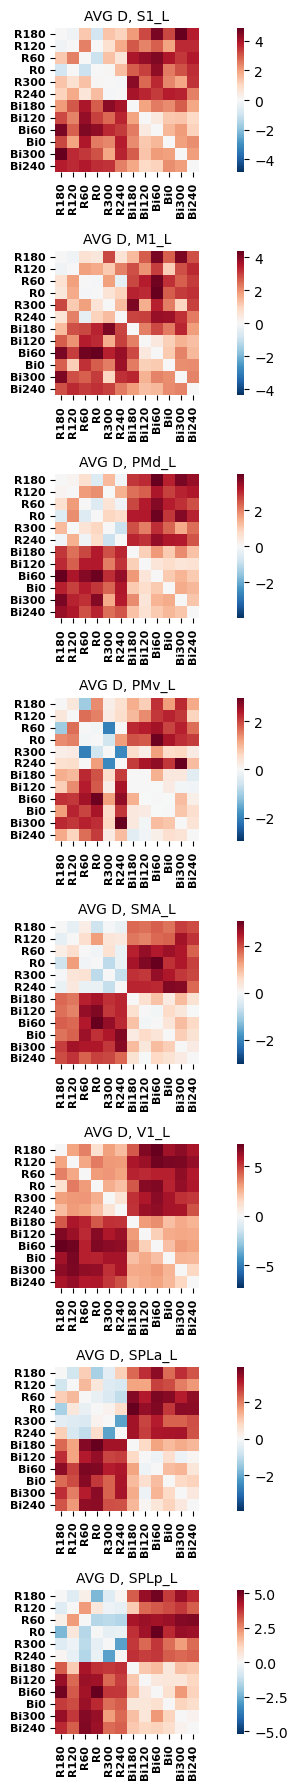

In [28]:
ana = pd.read_feather(os.path.join(analysisDir,'G_uni_bi_right.feather'))

rdm_cols = ['rhand:180','rhand:120','rhand:60','rhand:0','rhand:300','rhand:240',
            'bi:180','bi:120','bi:60','bi:0','bi:300','bi:240']
labels = ['R180','R120','R60','R0','R300','R240',
          'Bi180','Bi120','Bi60','Bi0','Bi300','Bi240']
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

sn_list = ana.sn.unique()
hem = ana.hem.unique()
regions = ana.region.unique()

D_avg = np.zeros((len(hem),len(regions), len(rdm_cols), len(rdm_cols)))
n_cond = len(rdm_cols)
cmap = matplotlib.cm.RdBu.reversed()
for sn in sn_list:
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,18))
    for j, h in enumerate(hem):
        for i, ax in enumerate(axes.flat):
            row = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==region_names[i])]
            D = utils.please.retrieve_matrix(row, prefix='D', colnames=rdm_cols)
            v_max = np.max(D)
            v_min = np.min(D)
            v_max = max(abs(v_max), abs(v_min))
            
            # cmap_reversed = cmap.reversed()
            sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
            ax.set_title(f'D, {region_names[i]}_{h}, s{sn}', fontsize=10)

            # Set labels manually with more formatting options
            ax.set_xticks(np.arange(0,n_cond)+0.5)
            ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
            ax.set_yticks(np.arange(0,n_cond)+0.5)
            ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')

            # avg RDMs:
            D_avg[j,i,:,:] = D_avg[j,i,:,:] + D/len(sn_list)
        
    plt.tight_layout()
    plt.savefig(f'../figures/D_uni_vs_bi/s{sn}_rightHand.pdf', bbox_inches="tight")
    plt.close()

# AVG D PLOT:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(8,18))
for j, h in enumerate(hem):
    for i, ax in enumerate(axes.flat):
        D = D_avg[j,i,:,:]
        v_max = np.max(D)
        v_min = np.min(D)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(D, cmap=cmap, square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
        ax.set_title(f'AVG D, {region_names[i]}_{h}', fontsize=10)
        
        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(labels, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(labels, rotation=0, fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../figures/D_uni_vs_bi/rightHand_avg.pdf', bbox_inches="tight")
plt.show()

